In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt

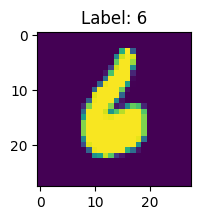

In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.figure(figsize=(2,2))
plt.title(f'Label: {Y_train[1337]}')
plt.imshow(X_train[1337])

In [15]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(784, 256)
    self.l2 = nn.Linear(256, 128)
    self.l3 = nn.Linear(128, 10)
  def forward(self, x):
    x = x.view(-1, 28*28).float()
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return x

Loss 0.23, Accuracy 0.91: 100%|██████████| 300/300 [00:00<00:00, 472.33it/s]


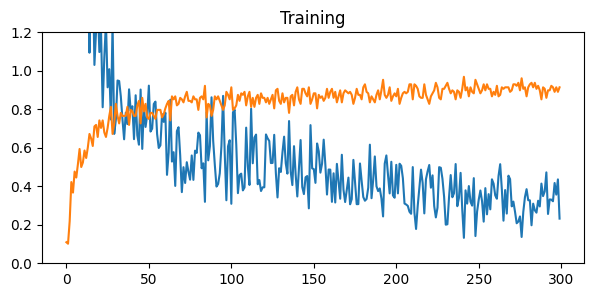

In [99]:
model = MLP()
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)
batch_size = 128
epochs = 300
losses, accuracies = [], []
for epoch in (t := trange(epochs)):
  model.zero_grad()
  samples = [random.randint(0,X_train.shape[0]-1) for x in range(batch_size)]
  X = torch.tensor(X_train[samples]) 
  y = torch.tensor(Y_train[samples]) 
  out = model(X)
  loss = loss_func(out, y)
  accuracy = (torch.argmax(out, dim=1).numpy() == Y_train[samples]).mean()
  losses.append(loss.item()), accuracies.append(accuracy.item())
  loss.backward()
  optim.step() 
  
  t.set_description(f"Loss {loss.item():.2f}, Accuracy {accuracy.item():.2f}")

plt.figure(figsize=(7,3))
plt.title('Training')
plt.ylim(0, 1.2)
plt.plot(losses)
plt.plot(accuracies)

In [100]:
#evaluation
out_eval = model(torch.tensor(X_test))
eval_acc = (torch.argmax(out_eval, dim=1).numpy() == Y_test).mean()
print(f'Accuracy on test dataset: {eval_acc * 100:.2f}')

Accuracy on test dataset: 90.59


In [102]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

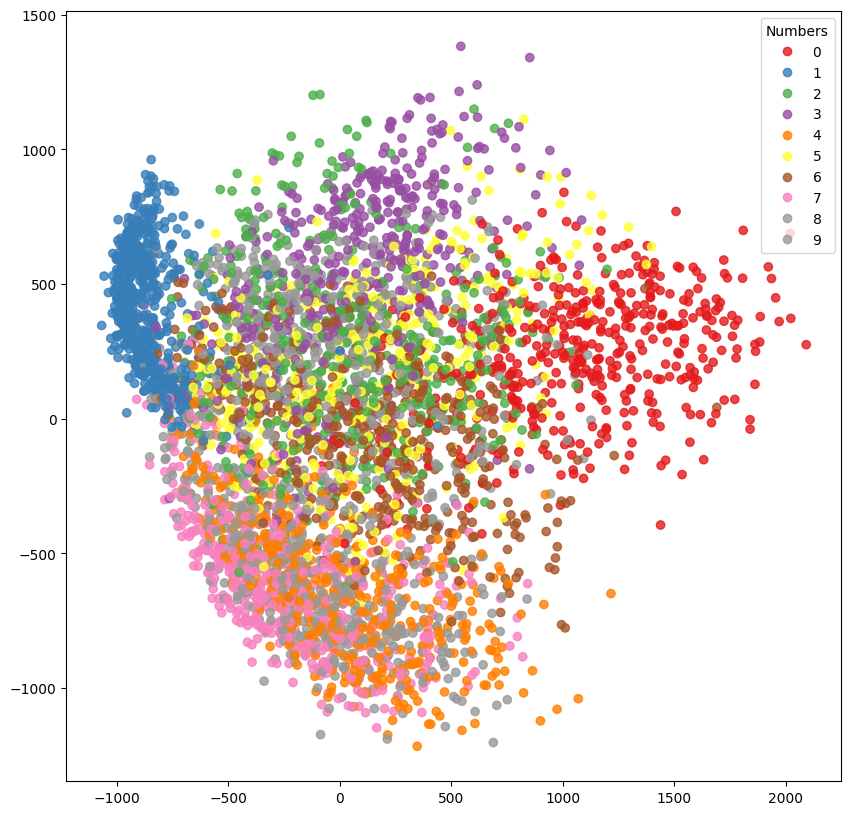

In [103]:
#visualising MNIST with PCA
samples = 5000
data = X_train[:samples]
labels = Y_train[:samples]
pca = PCA(n_components=2)
view = pca.fit_transform(data.reshape(data.shape[0],28*28))

fig, ax = plt.subplots(figsize=(10,10))
scat = ax.scatter(view[:,0], view[:,1], c=labels, alpha=0.8, cmap='Set1')
legend1 = ax.legend(*scat.legend_elements(num=10),
                    loc="upper right", title="Numbers")

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


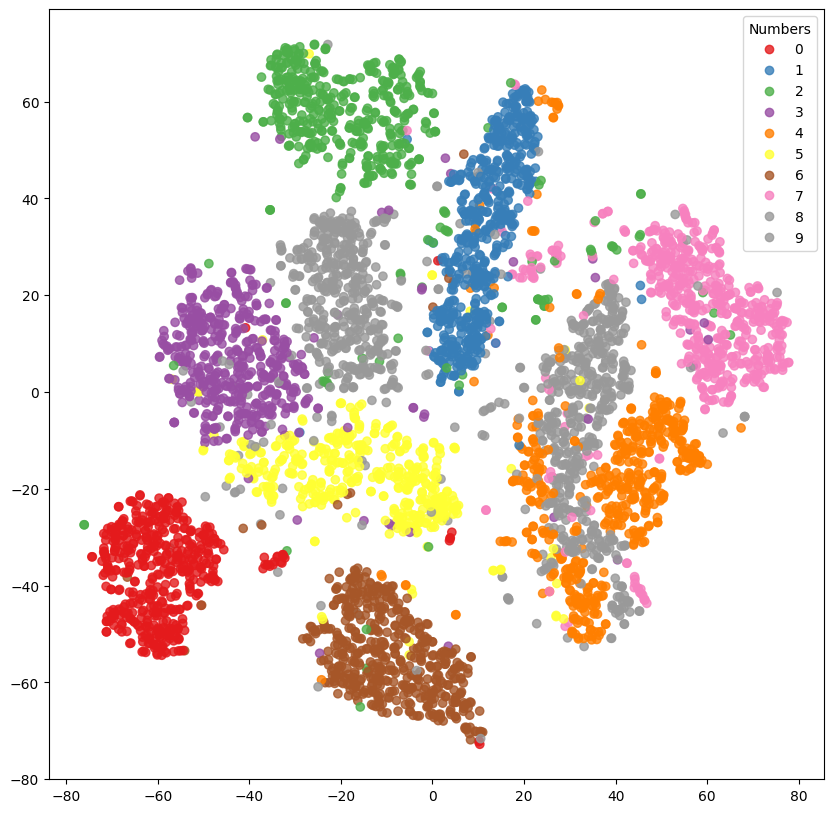

In [104]:
#visualizing mnist with t-sne
samples = 5000
data = X_train[:samples]
labels = Y_train[:samples]
view = TSNE(n_components=2, random_state=1337).fit_transform(data.reshape(data.shape[0],28*28))

fig, ax = plt.subplots(figsize=(10,10))
scat = ax.scatter(view[:,0], view[:,1], c=labels, alpha=0.8, cmap='Set1')
legend1 = ax.legend(*scat.legend_elements(num=10),
                    loc="upper right", title="Numbers")